## Categorical Perception: A Groundwork for Deep Learning
#### Laurent Bonnasse-Gahot & Jean-Pierre Nadal
Python notebook for reproducing the results presented in Section 3.3.2, Figure 8 (Categoricality as a function of layer depth, using the ImageNet dataset).

In [1]:
# force use of CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import os
import random
import numpy as np
import tensorflow as tf

# for reproducibility
SEED = 1
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rc={'font.size': 11, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('whitegrid', {'grid.linestyle': ':'})

In [4]:
if not os.path.exists('fig'):
    os.makedirs('fig')

In [5]:
from scipy import stats

from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

In [6]:
imagenet_folder = '/media/lbg/d84ccb5e-3b8d-4866-a439-10aaf995e6a9/data/images/ILSVRC2015/Data/CLS-LOC'

y_test_label = pd.read_csv(os.path.join(imagenet_folder,
                                        'devkit_2012', 'data',
                                        'ILSVRC2012_validation_ground_truth.txt'),
                           header=None)[0].to_numpy()

In [7]:
img_folder  = os.path.join(imagenet_folder, 'val')

In [8]:
n_classes = 1000

idx_per_class = [np.flatnonzero(y_test_label == i) for i in range(1,n_classes+1)]

In [9]:
model_0 = VGG16(weights=None)
model = VGG16(weights='imagenet')

In [10]:
def compute_pairs(idx_per_class, n_samples_within, n_samples_between):
    n_classes = len(idx_per_class)
        
    is_within = np.concatenate(([True]*n_samples_within,
                                [False]*n_samples_between))

    pairs = []
    for _ in range(n_samples_within):
        i = np.random.randint(n_classes)
        pairs.append(np.random.choice(idx_per_class[i], size=2, replace=False))
    for _ in range(n_samples_between):  
        i, j = np.random.choice(n_classes, size=2, replace=False)
        pairs.append([np.random.choice(idx_per_class[i]), 
                      np.random.choice(idx_per_class[j])])
    pairs = np.array(pairs)
    return pairs, is_within

In [11]:
# distance between two activities
def compute_similarity(act1, act2):
    return np.dot(act1, act2)/(np.linalg.norm(act1)*np.linalg.norm(act2))

def compute_distance(act1, act2):
    return 1 - compute_similarity(act1.flatten(), act2.flatten())

def compute_distance_between_pairs(activation, pairs, img_idx2id):
    n_layers = len(activation)
    dist_layers = []
    for i in range(n_layers):
        dist = []
        for idx1, idx2 in pairs:
            act1 = activation[i][img_idx2id[idx1]]
            act2 = activation[i][img_idx2id[idx2]]
            dist.append(compute_distance(act1, act2))
        dist_layers.append(np.array(dist))
    return np.array(dist_layers)

In [12]:
def get_activation_model(model):
    layer_outputs = [layer.output for layer in model.layers[1:]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    return activation_model

activation_model_0 = get_activation_model(model_0)
activation_model = get_activation_model(model)

In [13]:
# need to break down the process due to memory limitations
n_samples_within = 25
n_samples_between = 25

n_parts = 50
dist_layers_0 = []
dist_layers = []
is_withins = []
for part in range(n_parts):
    print('part {} / {}'.format(part+1, n_parts))
    pairs, is_within = compute_pairs(idx_per_class, n_samples_within, n_samples_between)
    
    is_withins.append(is_within)
    # img_ids[k] return the idx of image k in imgs
    img_ids = np.unique(pairs.flatten())

    # from the idx of an image, need to return its id
    img_idx2id = {img_id:i for i, img_id in enumerate(img_ids)}

    imgs = []
    for img_id in img_ids:
        img_path = os.path.join(img_folder, 'ILSVRC2012_val_{:08d}.JPEG'.format(img_id+1))
        x = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        imgs.append(x[0])

    imgs = np.array(imgs)
        
    activation_layers_0 = activation_model_0.predict(imgs)[:-1]
    dist_layers_0.append(compute_distance_between_pairs(activation_layers_0, pairs, img_idx2id))

    activation_layers = activation_model.predict(imgs)[:-1]
    dist_layers.append(compute_distance_between_pairs(activation_layers, pairs, img_idx2id))

dist_layers_0 = np.concatenate(dist_layers_0, axis=1)
dist_layers = np.concatenate(dist_layers, axis=1)
is_within = np.hstack(is_withins)

part 1 / 50
part 2 / 50
part 3 / 50
part 4 / 50
part 5 / 50
part 6 / 50
part 7 / 50
part 8 / 50
part 9 / 50
part 10 / 50
part 11 / 50
part 12 / 50
part 13 / 50
part 14 / 50
part 15 / 50
part 16 / 50
part 17 / 50
part 18 / 50
part 19 / 50
part 20 / 50
part 21 / 50
part 22 / 50
part 23 / 50
part 24 / 50
part 25 / 50
part 26 / 50
part 27 / 50
part 28 / 50
part 29 / 50
part 30 / 50
part 31 / 50
part 32 / 50
part 33 / 50
part 34 / 50
part 35 / 50
part 36 / 50
part 37 / 50
part 38 / 50
part 39 / 50
part 40 / 50
part 41 / 50
part 42 / 50
part 43 / 50
part 44 / 50
part 45 / 50
part 46 / 50
part 47 / 50
part 48 / 50
part 49 / 50
part 50 / 50


In [14]:
layers_name = [layer.name for layer in model.layers[1:]][:-1]
n_layers = len(layers_name)

# compute distance between the within and between distributions
ksstat_layers_0 = [0 for _ in range(n_layers)]

for idx_layer in range(n_layers):    
    dist = dist_layers_0[idx_layer, :]
    ksstat, _  = stats.ks_2samp(dist[~is_within], dist[is_within])
    ksstat_layers_0[idx_layer] = ksstat

ksstat_layers = [0 for _ in range(n_layers)]

for idx_layer in range(n_layers):    
    dist = dist_layers[idx_layer, :]
    ksstat, _  = stats.ks_2samp(dist[~is_within], dist[is_within])
    ksstat_layers[idx_layer] = ksstat

In [15]:
# compute bootstrap confidence intervals
n = is_within.shape[0]

n_boot = 1000

ksstat_layers_bs = [[] for _ in range(n_layers)]
ksstat_layers_0_bs = [[] for _ in range(n_layers)]
for idx_layer in range(n_layers): 
    dist = dist_layers[idx_layer, :]
    for _ in range(n_boot):
        idx_boot = np.random.choice(n, n)
        ksstat, _  = stats.ks_2samp(dist[idx_boot][~is_within[idx_boot]],
                                    dist[idx_boot][is_within[idx_boot]])
        ksstat_layers_bs[idx_layer].append(ksstat)
    dist = dist_layers_0[idx_layer, :]
    for _ in range(n_boot):
        idx_boot = np.random.choice(n, n)
        ksstat, _  = stats.ks_2samp(dist[idx_boot][~is_within[idx_boot]],
                                    dist[idx_boot][is_within[idx_boot]])
        ksstat_layers_0_bs[idx_layer].append(ksstat)

ksstat_layers_bs = np.array(ksstat_layers_bs)
ksstat_layers_0_bs = np.array(ksstat_layers_0_bs)

ksstat_layers_ci = []
ksstat_layers_0_ci = []
for idx_layer in range(n_layers):
    ksstat_layers_ci.append(sns.utils.ci(ksstat_layers_bs[idx_layer], which=95))
    ksstat_layers_0_ci.append(sns.utils.ci(ksstat_layers_0_bs[idx_layer], which=95))
ksstat_layers_ci = np.array(ksstat_layers_ci)
ksstat_layers_0_ci = np.array(ksstat_layers_0_ci)

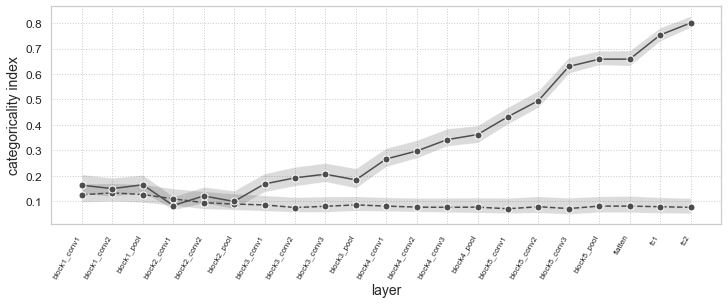

In [16]:
fh = plt.figure(figsize=(12,4))
plt.plot(ksstat_layers_0, 'o--', c='0.3', markersize=7, markeredgecolor='w')
plt.fill_between(np.arange(n_layers),
                 ksstat_layers_0_ci[:,0], 
                 ksstat_layers_0_ci[:,1], 
                 facecolor='0.3', alpha=0.2)
plt.plot(ksstat_layers, 'o-', c='0.3', markersize=7, markeredgecolor='w')
plt.fill_between(np.arange(n_layers),
                 ksstat_layers_ci[:,0], 
                 ksstat_layers_ci[:,1], 
                 facecolor='0.3', alpha=0.2)

plt.xlabel('layer')
plt.ylabel('categoricality index')
plt.xticks(range(n_layers), layers_name, rotation=60, ha='right', fontsize=8)
plt.show()
fh.savefig('fig/imagenet_vgg16_categoricality.pdf', bbox_inches='tight')